# EDA of Eedi Dataset
## Author: Bhavana Jonnalagadda


In [ ]:
# !pip install plotly 

In [32]:
import os
import ast

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "notebook+plotly_mimetype+png"
# pio.renderers.default = "png"
%matplotlib inline

## Data Description


We focus on the data available to tasks 3 and 4 as it is a much smaller dataset that is workable. The task descriptions from the paper "Instructions and Guide for
Diagnostic Questions: The NeurIPS 2020 Education Challenge":

- **The third task** is to predict the “quality” of a question, as defined by a panel of domain experts (experienced teachers), based on the information learned from the students’ answers found in the dataset. This task requires the definition of a metric for evaluating the question quality that mimics the experts’ judgement of the question quality. This is an unsupervised task.
- **The fourth task** is to interactively generate a sequence of questions to ask a student in order to maximise the predictive accuracy of a model on their remaining answers. Specifically, a participant’s model will be provided with a set of previously-unseen students, whose answers to questions are completely hidden, and a set of potential questions to query for each student. The model will then choose a personalized question to query for each of these students in turn, and then their corresponding answer will be revealed to the model. Based on this information, the model should choose a second question to query for each student, and so on, until 10 questions have been asked in total. The aim of the task is to maximise the predictive accuracy of a participant’s model on a held-out set of questions for each student, after the model has been exposed to the 10 answers from each student.


### Fields

- QuestionId: ID of the question answered.
- UserId: ID of the student who answered the question.
- AnswerId: Unique identifier for the (QuestionId, UserId) pair, used to join with associated answer metadata (see below).
- IsCorrect: Binary indicator for whether the student’s answer was correct (1 is correct, 0 is incorrect).
- CorrectAnswer: The correct answer to the multiple-choice question (value in [1,2,3,4]).
- AnswerValue: The student’s answer to the multiple-choice question (value in [1,2,3,4]).
- SubjectId: Each subject covers an area of mathematics, at varying degrees of gran- ularity. We provide IDs for each topic associated with a question in a list. Example topics could include “Algebra”, “Data and Statistics”, and “Geometry and Measure”. These subjects are arranged in a tree structure, so that for instance “Factorising” is the parent subject of “Factorising into a Single Bracket”. We provide details of this tree in an additional file subject metadata.csv which contains the subject name and tree level associated with each SubjectId, in addition to the SubjectId of its parent subject.
- Gender: The student’s gender, when available. 0 is unspecified, 1 is female, 2 is male and 3 is other.
- DateOfBirth: The student’s date of birth, rounded to the first of the month.
- PremiumPupil: Whether the student is eligible for free school meals or pupil pre-
mium due to being financially disadvantaged.
- DateAnswered: Time and date that the question was answered, to the nearest minute.
- Confidence: Percentage confidence score given for the answer. 0 means a random guess, 100 means total confidence.
- GroupId: The class (group of students) in which the student was assigned the question.
- QuizId: The assigned quiz which contains the question the student answered. SchemeOfWorkId: The scheme of work in which the student was assigned the
question.

## Load and format data

In [66]:
# Use normpath to make work on windows machines
data_dir = os.path.normpath("../data/")
eedi_dir = os.path.join(data_dir, "Eedi_dataset")
eedi_metadata_dir = os.path.join(eedi_dir, "metadata")

df_train = pd.read_csv(os.path.join(eedi_dir, "train_data", "train_task_3_4.csv"))
df_answer = pd.read_csv(os.path.join(eedi_metadata_dir, "answer_metadata_task_3_4.csv"), parse_dates=["DateAnswered"])
df_student = pd.read_csv(os.path.join(eedi_metadata_dir, "student_metadata_task_3_4.csv"), parse_dates=["DateOfBirth"])
df_question = pd.read_csv(os.path.join(eedi_metadata_dir, "question_metadata_task_3_4.csv"))
df_subject = pd.read_csv(os.path.join(eedi_metadata_dir, "subject_metadata.csv"))

# Join the datasets on the relevant keys, so that we only have to work with two DFs: df_total and df_subject
df_total = df_train.join(df_answer.set_index('AnswerId'), on="AnswerId")\
                    .join(df_student.set_index("UserId"), on="UserId")\
                    .join(df_question.set_index("QuestionId"), on="QuestionId")
# Convert str col to proper dtype, list of ints
df_total.SubjectId = df_total.SubjectId.apply(ast.literal_eval)

# Make column with strs of the parentId
subject_mapping = pd.Series(df_subject.Name.values,index=df_subject.SubjectId).to_dict()
df_subject["ParentName"] = df_subject.ParentId.map(subject_mapping)

print(df_subject)
df_total

     SubjectId                       Name  ParentId  Level   
0            3                      Maths       NaN      0  \
1           32                     Number       3.0      1   
2           33                     BIDMAS     144.0      3   
3           34     Upper and Lower Bounds     141.0      3   
4           35             Calculator Use      32.0      2   
..         ...                        ...       ...    ...   
383       1982  Mixed operation Fractions      39.0      3   
384       1983               Drawing Axes      54.0      3   
385       1985             Reading Scales      98.0      3   
386       1987             Sorting Shapes     174.0      3   
387       1988           Labelling Shapes     174.0      3   

                            ParentName  
0                                  NaN  
1                                Maths  
2                     Basic Arithmetic  
3              Rounding and Estimating  
4                               Number  
..       

QuestionId  UserId  AnswerId  IsCorrect  CorrectAnswer  AnswerValue   
0               898    2111    280203          1              2            2  \
1               767    3062     55638          1              3            3   
2               165    1156    386475          1              2            2   
3               490    1653    997498          1              4            4   
4               298    3912    578636          1              3            3   
...             ...     ...       ...        ...            ...          ...   
1382722          80    2608     57945          1              2            2   
1382723         707    2549    584230          0              2            1   
1382724         840    5901   1138956          1              1            1   
1382725         794    3854   1151183          0              1            3   
1382726         157    3184   1321883          1              3            3   

               DateAnswered  Confidence  GroupId  QuizId  SchemeOfWorkId   
0       2019-12-08 17:47:00         NaN       95      86         52562.0  \
1       2019-10-27 20:54:00        25.0      115      39         52562.0   
2       2019-10-06 20:16:00         NaN      101      39         52562.0   
3       2020-02-27 17:40:00         NaN       46     115         52562.0   
4       2019-12-27 16:07:00         NaN      314      78         52562.0   
...                     ...         ...      ...     ...             ...   
1382722 2019-11-28 15:22:00         NaN      270      65         52562.0   
1382723 2020-01-06 16:26:00         NaN      269     109         52562.0   
1382724 2020-01-07 07:14:00         NaN      270      66         52562.0   
1382725 2019-12-15 16:32:00         NaN      339       9         52562.0   
1382726 2020-01-07 10:02:00         NaN       27      66         52562.0   

         Gender DateOfBirth  PremiumPupil          SubjectId  
0             2  2007-09-01           0.0    [3, 49, 62, 70]  
1             0         NaT           NaN  [3, 32, 144, 204]  
2             0         NaT           NaN   [3, 32, 37, 220]  
3             0         NaT           NaN   [3, 49, 81, 406]  
4             2  2008-04-01           0.0   [3, 71, 74, 180]  
...         ...         ...           ...                ...  
1382722       0         NaT           NaN   [3, 32, 42, 211]  
1382723       2  2007-11-01           0.0   [3, 32, 42, 212]  
1382724       0         NaT           NaN   [3, 32, 37, 219]  
1382725       0         NaT           NaN    [3, 49, 62, 70]  
1382726       2  2008-02-01           0.0   [3, 32, 37, 219]  

[1382727 rows x 15 columns]

## EDA

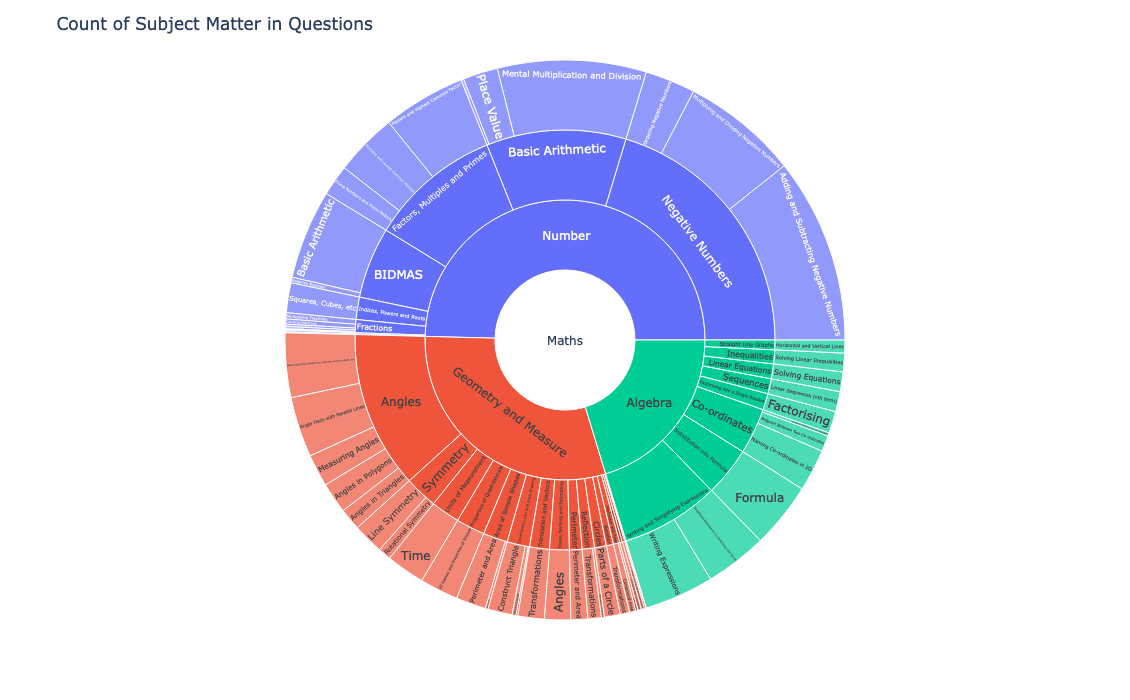

In [112]:
# Turn list of subjects into a count of each hierarchical combo, with the subjects replaced as columns
df_subject_counts = pd.DataFrame(df_total.SubjectId.value_counts()).reset_index()
df_subject_counts = pd.concat([df_subject_counts.drop(columns='SubjectId'), pd.DataFrame(df_subject_counts['SubjectId'].tolist(), index=df_subject_counts.index).add_prefix('Subject')], 
               axis=1)
df_subject_counts.iloc[:, 1:] = df_subject_counts.iloc[:, 1:].applymap(subject_mapping.get)
df_subject_counts = df_subject_counts.replace({np.NaN: None})

fig = px.sunburst(df_subject_counts, path=["Subject" + str(i) for i in range(4)], values='count')
fig.update_layout(title="Count of Subject Matter in Questions", height=700)
fig.show()

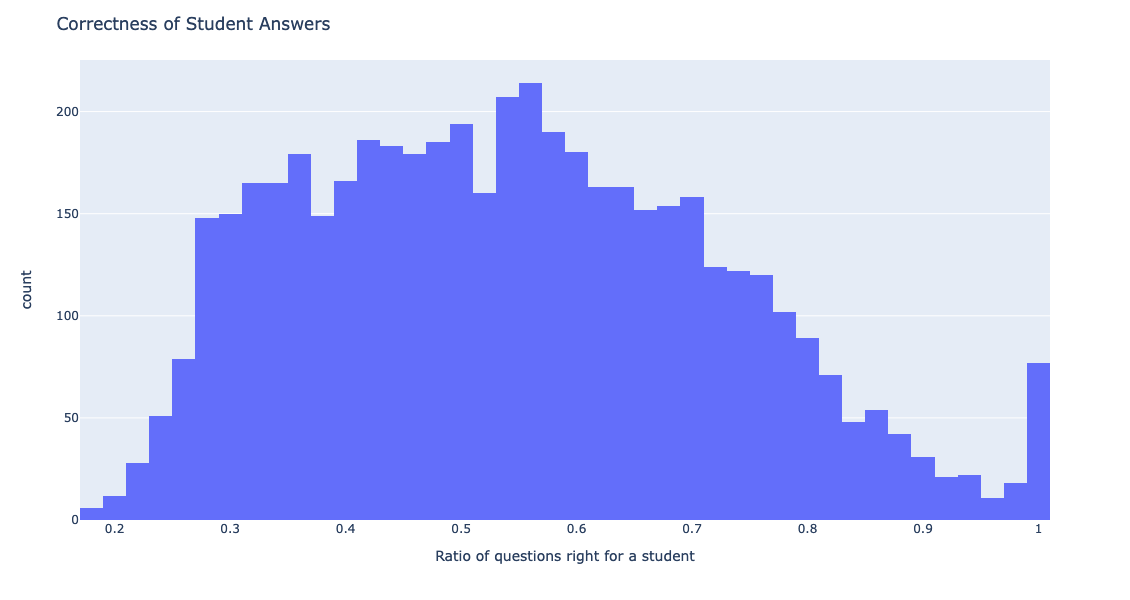

In [120]:
fig = px.histogram(x=df_total.groupby("UserId")["IsCorrect"].mean())
fig.update_layout(title="Correctness of Student Answers", height=600, xaxis_title="Ratio of questions right for a student")
fig.show()

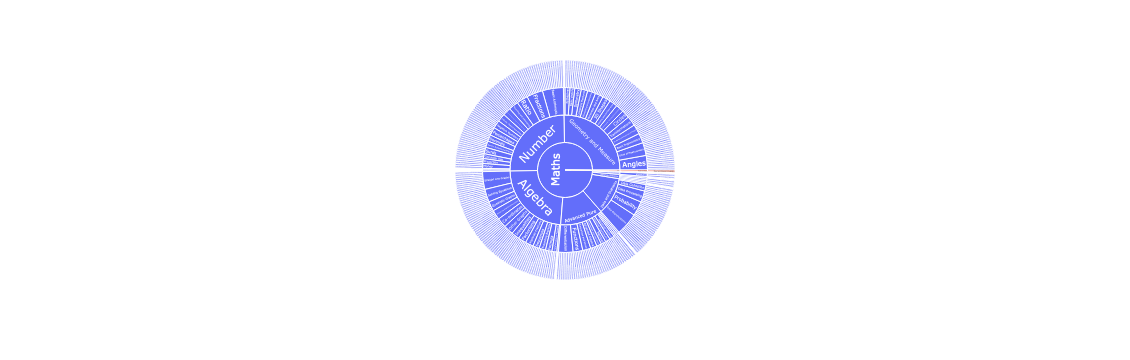

In [68]:
fig = px.sunburst(df_subject, names='Name', parents='ParentName')
fig.show()